# CIFAR-10 NN 1 task for NSU

Условия и требования:
- (+) Разбить модель на обучающую и валидационную (тестовую) выборки
- (+) Модель только на полносвязных слоях
- (+) Модель со сверточными слоями
- (+) Разное количество слоев (и нейронов в слоях)
- (+) Дропаут
- (+) Batch Normalization
- (+) Различные функции активации
- (???) Различная инициализация весов
- (+) Различные оптимизаторы
- (+) Различные расписания обучения (learning rate scheduler)
- (+) Разные размеры batch-а и скорости обучения

## Imports

In [41]:
import os.path

import torch
from torch import nn
from torch.utils.data import DataLoader

import torchmetrics
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import mlxtend
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

from timeit import default_timer as timer
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

import random
import typing
import itertools


import sys
if not sys.path.__contains__('..'):
    sys.path.insert(0, '..')
import helper

from pathlib import Path

In [ ]:
import importlib

importlib.reload(helper)

## Set constants

In [3]:
BATCH_SIZE = 32
NUM_WORKERS = 4
SEED = 42
device = "cuda" if torch.cuda.is_available() else "cpu"

## Acquire dataset

In [4]:
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

train_dataset = datasets.CIFAR10(
    root="dataCifar",
    train=True,
    transform=ToTensor(),
    download=True
)
test_dataset = datasets.CIFAR10(
    root="dataCifar",
    train=False,
    transform=ToTensor(),
    download=True,
)
class_names = train_dataset.classes
len(train_dataset), len(test_dataset)

Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

## Convert in dataloaders

In [5]:
torch.manual_seed(SEED)
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    persistent_workers=True
)
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    persistent_workers=True
)

In [6]:


test_flatten = nn.Flatten
sample_features_batch, sample_labels_batch = next(iter(train_dataloader))
sample_features_batch.shape, sample_labels_batch.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

Накидаем 2 модельки - линейную и нелинейную и попробуем как-то обучить. Из ожиданий - линейная вообще глупой должна быть, нелинейная чуть получше

## Fully-connected Linear NN Model

In [7]:
class FullyConnectedLinearModel(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape, name):
        super().__init__()
        self.name = name
        self.layerstack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=input_shape,
                out_features=hidden_units
            ),
            nn.Linear(
                in_features=hidden_units,
                out_features=output_shape
            ),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        res = self.layerstack(x)
        return res

## Fully-connected Non-linear NN model

In [8]:
class FullyConnectedNonLinearModel(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape, name):
        super().__init__()
        self.name = name
        self.layerstack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=input_shape,
                out_features=hidden_units
            ),
            nn.ReLU(),
            nn.Linear(
                in_features=hidden_units,
                out_features=hidden_units
            ),
            nn.ReLU(),
            nn.Linear(
                in_features=hidden_units,
                out_features=output_shape
            ),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        res = self.layerstack(x)
        return res

### Set up loss, eval functions

In [9]:

loss_function = nn.CrossEntropyLoss()

accuracy = torchmetrics.Accuracy(
    task="multiclass",
    num_classes=len(class_names),
    device=device
).to(device)

f1 = torchmetrics.F1Score(
    task="multiclass",
    num_classes=len(class_names),
    device=device
).to(device)


def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

input_shape = 3 * 32 * 32
learning_rates = [0.001, 0.01, 0.05, 0.1, 1]
hidden_units = [10, 100, 1000]

model_results = []
models_pool = []

learning_rates.reverse()

for lr in learning_rates:
    models_cache = []
    for hu in hidden_units:
        fcl_model = FullyConnectedLinearModel(
            input_shape=input_shape,
            hidden_units=hu,
            output_shape=len(class_names),
            name=f"fcl{hu}/{lr}"
        ).to(device)
        fcnl_model = FullyConnectedNonLinearModel(
            input_shape=input_shape,
            hidden_units=hu,
            output_shape=len(class_names),
            name=f"fcnl{hu}/{lr}"
        ).to(device)
        models_cache.extend([fcl_model, fcnl_model])
    for model in models_cache:
        optimizer = torch.optim.SGD(
            params=model.parameters(),
            lr=lr
        )
        results = helper.model_trainer(
            model=model,
            epochs=3,
            # к сожалению перебор - штука трудоёмная, поэтому 3 эпохи должны дать просто примерное представление об обучаемости
            train_dataloader=train_dataloader,
            test_dataloader=test_dataloader,
            loss_function=loss_function,
            optimizer=optimizer,
            eval_function=f1,
            device=device
        )
        model_results.append(results)
        models_pool.append(model)

In [175]:
results_df = pd.DataFrame(model_results)
print(f"Total train time of all models = {results_df['train_time'].sum() / 60:.2f} minutes")

Total train time of all models = 10.72 minutes


In [177]:
results_df.set_index(keys=['status', "learning_rate"])

,,name,class_name,epochs_remain,on_which_batch_broken,train_time,loss_function,optimizer,eval_function,device,end_test_loss,end_test_eval,end_train_loss,end_train_eval,history_test_loss,history_test_eval,history_train_loss,history_train_eval
status,learning_rate,,,,,,,,,,,,,,,,,
TrainStatus.GradientExplosion,1.000,fcl10/1,FullyConnectedLinearModel,2,17.0,12.351602,CrossEntropyLoss,SGD,MulticlassF1Score,cuda,0.000000,0.000000,0.000000,0.000000,[],[],[0],[0]
TrainStatus.Success,1.000,fcnl10/1,FullyConnectedNonLinearModel,0,NaN,34.950865,CrossEntropyLoss,SGD,MulticlassF1Score,cuda,2.360345,0.099740,2.360978,0.100048,"[2.26325, 2.36091, 2.36035]","[0.1903, 0.10014, 0.09974]","[2.25259, 2.36014, 2.36098]","[0.18658, 0.10087, 0.10005]"
TrainStatus.GradientExplosion,1.000,fcl100/1,FullyConnectedLinearModel,2,17.0,0.178372,CrossEntropyLoss,SGD,MulticlassF1Score,cuda,0.000000,0.000000,0.000000,0.000000,[],[],[0],[0]
TrainStatus.Success,1.000,fcnl100/1,FullyConnectedNonLinearModel,0,NaN,27.408624,CrossEntropyLoss,SGD,MulticlassF1Score,cuda,2.358540,0.102536,2.355825,0.105326,"[2.35778, 2.361, 2.35854]","[0.10323, 0.10014, 0.10254]","[2.27318, 2.33785, 2.35582]","[0.17702, 0.12296, 0.10533]"
TrainStatus.GradientExplosion,1.000,fcl1000/1,FullyConnectedLinearModel,2,17.0,0.289406,CrossEntropyLoss,SGD,MulticlassF1Score,cuda,0.000000,0.000000,0.000000,0.000000,[],[],[0],[0]
TrainStatus.Success,1.000,fcnl1000/1,FullyConnectedNonLinearModel,0,NaN,28.550635,CrossEntropyLoss,SGD,MulticlassF1Score,cuda,2.359500,0.101637,2.343693,0.117442,"[2.30936, 2.3573, 2.3595]","[0.15156, 0.10383, 0.10164]","[2.25774, 2.32111, 2.34369]","[0.19168, 0.13974, 0.11744]"
TrainStatus.GradientExplosion,0.100,fcl10/0.1,FullyConnectedLinearModel,2,88.0,0.518521,CrossEntropyLoss,SGD,MulticlassF1Score,cuda,0.000000,0.000000,0.000000,0.000000,[],[],[0],[0]
TrainStatus.Success,0.100,fcnl10/0.1,FullyConnectedNonLinearModel,0,NaN,26.485830,CrossEntropyLoss,SGD,MulticlassF1Score,cuda,2.152829,0.297224,2.154085,0.296265,"[2.20007, 2.18951, 2.15283]","[0.2474, 0.25419, 0.29722]","[2.23992, 2.17714, 2.15408]","[0.19746, 0.27017, 0.29627]"
TrainStatus.GradientExplosion,0.100,fcl100/0.1,FullyConnectedLinearModel,2,88.0,0.449692,CrossEntropyLoss,SGD,MulticlassF1Score,cuda,0.000000,0.000000,0.000000,0.000000,[],[],[0],[0]


#### Оценка результата обучения линейных и нелинейных полносвязных моделей

(интересное наблюдение - взорвались линейные модели, но не модели на Relu, хотя судя по всему должно быть наоборот...)

In [178]:
best_models = results_df.sort_values(by="end_test_eval", ascending=False).head(3)
fastest_trained_models = results_df[results_df.status != helper.TrainStatus.GradientExplosion].sort_values(
    by="train_time", ascending=True).head(3)

In [179]:
best_models  # как и можно ожидать - скор удручающий, но можно попробовать потренировать лучшую модель на большем количестве батчей и посмотреть прогрессию

,name,class_name,status,epochs_remain,on_which_batch_broken,train_time,loss_function,optimizer,learning_rate,eval_function,device,end_test_loss,end_test_eval,end_train_loss,end_train_eval,history_test_loss,history_test_eval,history_train_loss,history_train_eval
20,fcl100/0.01,FullyConnectedLinearModel,TrainStatus.Success,0,NaN,23.139439,CrossEntropyLoss,SGD,0.01,MulticlassF1Score,cuda,1.772987,0.381689,1.786317,0.377739,"[1.84864, 1.80118, 1.77299]","[0.34305, 0.36601, 0.38169]","[1.94162, 1.81813, 1.78632]","[0.31092, 0.36124, 0.37774]"
18,fcl10/0.01,FullyConnectedLinearModel,TrainStatus.Success,0,NaN,22.900937,CrossEntropyLoss,SGD,0.01,MulticlassF1Score,cuda,1.774266,0.381390,1.794698,0.370961,"[1.94232, 1.81111, 1.77427]","[0.311, 0.36861, 0.38139]","[1.97109, 1.83595, 1.7947]","[0.29295, 0.35091, 0.37096]"
12,fcl10/0.05,FullyConnectedLinearModel,TrainStatus.Success,0,NaN,23.223012,CrossEntropyLoss,SGD,0.05,MulticlassF1Score,cuda,1.774932,0.376797,1.816814,0.361864,"[1.85156, 1.97658, 1.77493]","[0.33866, 0.30541, 0.3768]","[1.93788, 1.84059, 1.81681]","[0.30502, 0.34961, 0.36186]"


In [180]:
fastest_trained_models

,name,class_name,status,epochs_remain,on_which_batch_broken,train_time,loss_function,optimizer,learning_rate,eval_function,device,end_test_loss,end_test_eval,end_train_loss,end_train_eval,history_test_loss,history_test_eval,history_train_loss,history_train_eval
18,fcl10/0.01,FullyConnectedLinearModel,TrainStatus.Success,0,NaN,22.900937,CrossEntropyLoss,SGD,0.01,MulticlassF1Score,cuda,1.774266,0.381390,1.794698,0.370961,"[1.94232, 1.81111, 1.77427]","[0.311, 0.36861, 0.38139]","[1.97109, 1.83595, 1.7947]","[0.29295, 0.35091, 0.37096]"
14,fcl100/0.05,FullyConnectedLinearModel,TrainStatus.Success,0,NaN,23.136259,CrossEntropyLoss,SGD,0.05,MulticlassF1Score,cuda,1.799187,0.352137,1.814598,0.360045,"[1.8938, 1.83597, 1.79919]","[0.32179, 0.34065, 0.35214]","[1.93278, 1.83691, 1.8146]","[0.31024, 0.34925, 0.36004]"
20,fcl100/0.01,FullyConnectedLinearModel,TrainStatus.Success,0,NaN,23.139439,CrossEntropyLoss,SGD,0.01,MulticlassF1Score,cuda,1.772987,0.381689,1.786317,0.377739,"[1.84864, 1.80118, 1.77299]","[0.34305, 0.36601, 0.38169]","[1.94162, 1.81813, 1.78632]","[0.31092, 0.36124, 0.37774]"


#### Попробуем дотренировать лучшую модель

In [181]:
best_model = None
name = best_models.set_index(keys="name").iloc[
    0].name  # видимо там в пандасе встроенные имена есть, и без set_index оно выводит просто номер в изначальной таблице
lr = best_models.set_index(keys="name").iloc[0].learning_rate
for model in models_pool:
    if model.name == name:
        best_model = model
        break

In [ ]:
optimizer = torch.optim.SGD(
    params=best_model.parameters(),
    lr=lr / 10  # сбавим скорость обучения
)

best_model.name = best_model.name + "BEST"

best_results = helper.model_trainer(
    model=best_model,
    epochs=20,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_function=loss_function,
    optimizer=optimizer,
    eval_function=f1,
    device=device
)

In [184]:
model_results.append(best_results)

In [185]:
best_results

{'name': 'fcl100/0.01BEST',
 'class_name': 'FullyConnectedLinearModel',
 'status': <TrainStatus.Success: 1>,
 'epochs_remain': 0,
 'on_which_batch_broken': None,
 'train_time': 176.72460800001863,
 'loss_function': 'CrossEntropyLoss',
 'optimizer': 'SGD',
 'learning_rate': 0.001,
 'eval_function': 'MulticlassF1Score',
 'device': 'cuda',
 'end_test_loss': 1.7256218194961548,
 'end_test_eval': 0.4057507812976837,
 'end_train_loss': 1.7080295085906982,
 'end_train_eval': 0.41482725739479065,
 'history_test_loss': [1.74655,
  1.74762,
  1.74375,
  1.74144,
  1.74207,
  1.73896,
  1.73852,
  1.73586,
  1.73602,
  1.73422,
  1.73259,
  1.73739,
  1.73618,
  1.73047,
  1.73028,
  1.73101,
  1.72881,
  1.72565,
  1.72634,
  1.72562],
 'history_test_eval': [0.39537,
  0.39726,
  0.39986,
  0.39836,
  0.39926,
  0.40066,
  0.40126,
  0.40006,
  0.40315,
  0.40355,
  0.40385,
  0.40026,
  0.39796,
  0.40226,
  0.40246,
  0.40375,
  0.40166,
  0.40216,
  0.40256,
  0.40575],
 'history_train_loss':

  0%|          | 0/313 [00:00<?, ?it/s]

torch.Size([10000])
{'name': 'FullyConnectedLinearModel', 'loss': 1.7256218194961548, 'eval': 0.4057507812976837, 'train_time': 0, 'predicted': tensor([3, 9, 8,  ..., 5, 4, 7], device='cuda:0')}
              precision    recall  f1-score   support

    airplane       0.44      0.45      0.45      1000
  automobile       0.42      0.55      0.48      1000
        bird       0.30      0.23      0.26      1000
         cat       0.31      0.25      0.28      1000
        deer       0.37      0.33      0.35      1000
         dog       0.36      0.33      0.35      1000
        frog       0.43      0.49      0.46      1000
       horse       0.47      0.43      0.45      1000
        ship       0.44      0.56      0.49      1000
       truck       0.45      0.42      0.44      1000

    accuracy                           0.41     10000
   macro avg       0.40      0.41      0.40     10000
weighted avg       0.40      0.41      0.40     10000



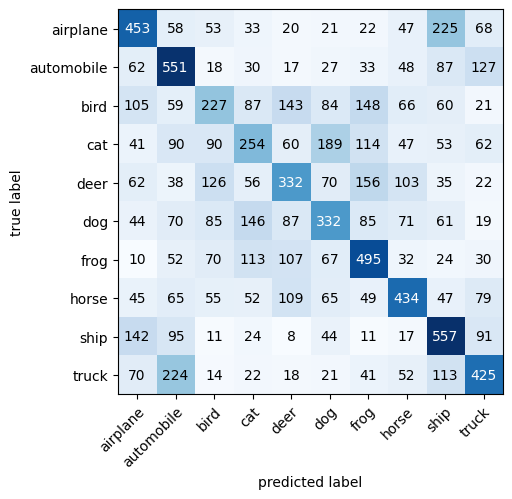

In [186]:
helper.model_eval_report(
    model=best_model,
    test_dataset=test_dataset,
    test_dataloader=test_dataloader,
    loss_function=loss_function,
    eval_function=f1,
    device=device
)

Как можно заметить, мы вышли на плато в 45-50% F1, уже не рандомные предсказания, но нас это не особо устраивает, поэтому попробуем применить другие методы.

Все эти модели не считаю нужным сохранять, поскольку они мусорные, и их быстрее будет натренировать заново, чем писать сейчас сейв обертку

## Convolutional NN TinyVGG

In [188]:
class TinyVGGModel(nn.Module):
    def __init__(self,
                 name: typing.AnyStr,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.name = name
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,  # channels
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=output_shape * 8 * 8,
                out_features=output_shape
            )
        )

    def forward(self, x):
        x = self.conv_block1(x)
        # print(x.shape)
        x = self.conv_block2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [189]:
torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)

tiny_vgg_model = TinyVGGModel(
    name="cnnTinyVGG10/0.03",
    input_shape=3,
    hidden_units=10,
    output_shape=len(class_names)
)

Посмотрим, какая размерность нужна на входе слоя classifier. Выяснили, что 10х8х8 (при помощи намеренного выброса ошибки удобно смотреть)

![](./images/razmernost.png)

In [190]:
# rand_batch_tensor = torch.randn(size=(32,3,32,32))
# tiny_vgg_model(rand_batch_tensor)

(тут уже без перебора, прошу прощения, но модель должна справиться и так, а навыки перебора гиперпараметров в целом продемонстрировал на примере выше)

In [ ]:
torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)

optimizer = torch.optim.SGD(
    params=tiny_vgg_model.parameters(),
    lr=0.03
)
tiny_vgg_results = helper.model_trainer(
    model=tiny_vgg_model,
    epochs=30,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_function=loss_function,
    optimizer=optimizer,
    eval_function=f1,
    device=device
)

In [192]:
model_results.append(tiny_vgg_results)

In [193]:
tiny_vgg_results_pd = pd.DataFrame([tiny_vgg_results])
tiny_vgg_results_pd

,name,class_name,status,epochs_remain,on_which_batch_broken,train_time,loss_function,optimizer,learning_rate,eval_function,device,end_test_loss,end_test_eval,end_train_loss,end_train_eval,history_test_loss,history_test_eval,history_train_loss,history_train_eval
0,cnnTinyVGG10/0.03,TinyVGGModel,TrainStatus.Success,0,None,352.81773,CrossEntropyLoss,SGD,0.03,MulticlassF1Score,cuda,1.078839,0.630791,0.919992,0.676444,"[1.995, 1.64463, 1.39291, 1.3265, 1.35343, 1.2...","[0.29113, 0.41274, 0.4989, 0.53165, 0.52606, 0...","[2.18885, 1.80085, 1.49339, 1.35918, 1.27983, ...","[0.18282, 0.35081, 0.46687, 0.51887, 0.54649, ..."


Ориентировочный потолок текущих исчислений - 65-70 f1

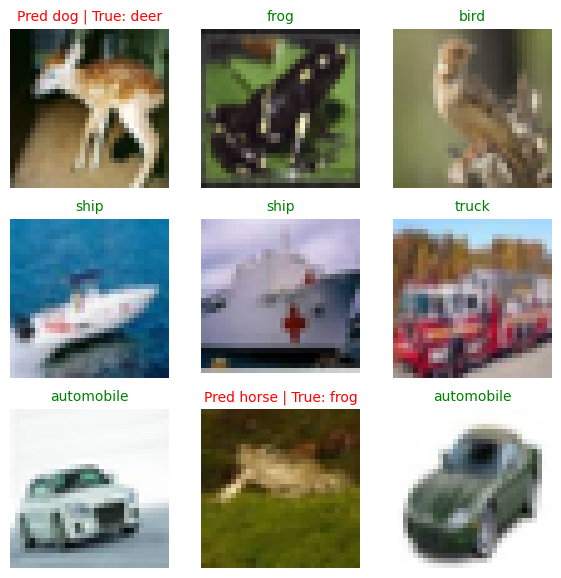

In [194]:
helper.plot_random_samples(
    test_data=test_dataset,
    model=tiny_vgg_model,
    device=device,
    class_names=class_names,
    figsize=7,
    rows_cols=3,
)

После метода пристального взгляда на получившиеся предикты - могу сказать, что очень много картинок есть, которые даже человек не опознает.

  0%|          | 0/313 [00:00<?, ?it/s]

torch.Size([10000])
{'name': 'TinyVGGModel', 'loss': 1.078838586807251, 'eval': 0.6307907104492188, 'train_time': 0, 'predicted': tensor([8, 8, 0,  ..., 5, 0, 7], device='cuda:0')}
              precision    recall  f1-score   support

    airplane       0.57      0.77      0.66      1000
  automobile       0.70      0.81      0.75      1000
        bird       0.54      0.53      0.53      1000
         cat       0.48      0.41      0.44      1000
        deer       0.70      0.44      0.54      1000
         dog       0.50      0.62      0.55      1000
        frog       0.77      0.63      0.69      1000
       horse       0.73      0.63      0.67      1000
        ship       0.69      0.80      0.74      1000
       truck       0.72      0.68      0.70      1000

    accuracy                           0.63     10000
   macro avg       0.64      0.63      0.63     10000
weighted avg       0.64      0.63      0.63     10000



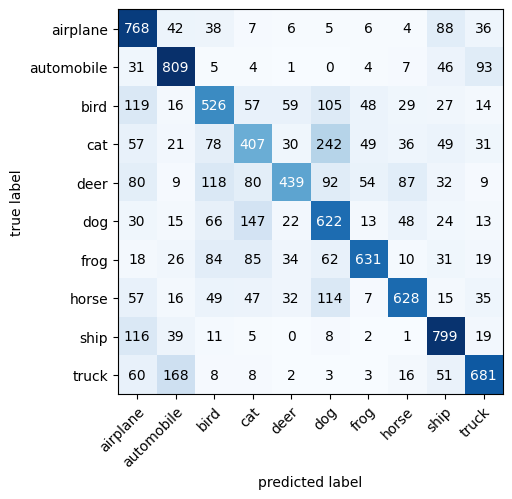

In [195]:
torch.manual_seed(SEED)

helper.model_eval_report(
    tiny_vgg_model,
    test_dataloader,
    test_dataset,
    loss_function,
    f1,
    device
)

Возможно я что-то не то сделал, но это вообще не похоже на 65% f1 (точность примерно та же)


((На момент написания этого комментария, я не отключил шаффл на тесте и у меня просто выбивало рандомную матрицу. Картинка ниже иллюстрирует всю боль, которую я испытывал 3 часа, пытаясь понять где проблема))

![](./images/random_matrix.png)

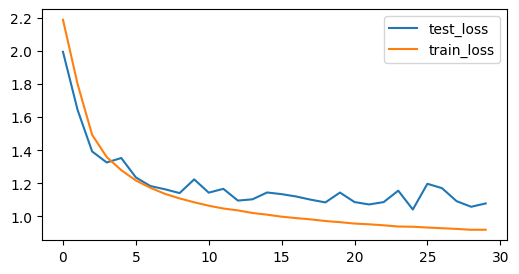

In [197]:
plt.rcParams['figure.figsize'] = [6, 3]
plt.plot(tiny_vgg_results_pd.history_test_loss[0], label='test_loss')
plt.plot(tiny_vgg_results_pd.history_train_loss[0], label='train_loss')
plt.legend()

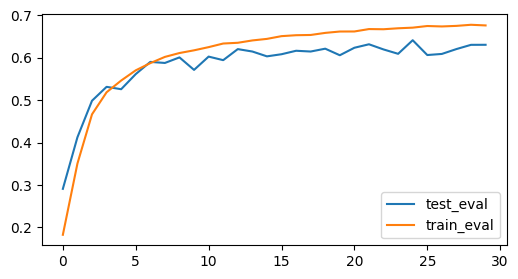

In [198]:
plt.rcParams['figure.figsize'] = [6, 3]
plt.plot(tiny_vgg_results_pd.history_test_eval[0], label='test_eval')
plt.plot(tiny_vgg_results_pd.history_train_eval[0], label='train_eval')
plt.legend()

Попробую поменять оптимизатор и добавить расписание скорости обучения

In [ ]:
torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)

tiny_vgg_model_adam = TinyVGGModel(
    name="cnnVGG10/sched",
    input_shape=3,
    hidden_units=10,
    output_shape=len(class_names)
)

optimizer = torch.optim.Adam(
    params=tiny_vgg_model_adam.parameters(),
    lr=0.003
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
tiny_vgg_results_adam = helper.model_trainer(
    model=tiny_vgg_model_adam,
    epochs=30,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_function=loss_function,
    optimizer=optimizer,
    eval_function=f1,
    device=device,
    scheduler=scheduler
)

In [200]:
model_results.append(tiny_vgg_results_adam)

In [201]:
tiny_vgg_results_adam_df = pd.DataFrame([tiny_vgg_results_adam])

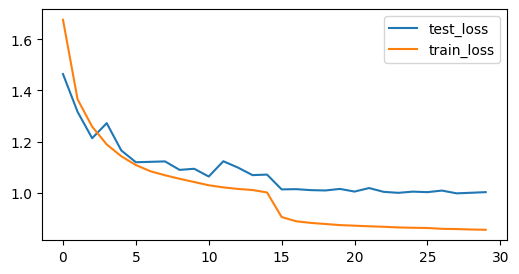

In [202]:
plt.rcParams['figure.figsize'] = [6, 3]
plt.plot(tiny_vgg_results_adam_df.history_test_loss[0], label='test_loss')
plt.plot(tiny_vgg_results_adam_df.history_train_loss[0], label='train_loss')
plt.legend()

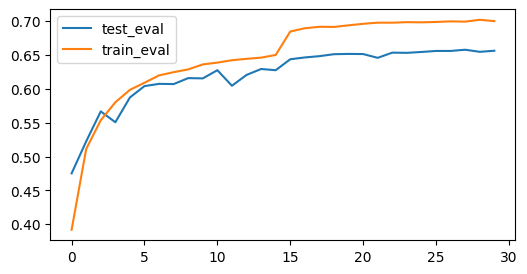

In [203]:
plt.rcParams['figure.figsize'] = [6, 3]
plt.plot(tiny_vgg_results_adam_df.history_test_eval[0], label='test_eval')
plt.plot(tiny_vgg_results_adam_df.history_train_eval[0], label='train_eval')
plt.legend()

И всё равно больше 65% не получается уйти с этой моделью, даже с учетом смены оптимизатора, увеличения эпох и расписания ЛР

  0%|          | 0/313 [00:00<?, ?it/s]

torch.Size([10000])
{'name': 'TinyVGGModel', 'loss': 1.0016472339630127, 'eval': 0.65625, 'train_time': 0, 'predicted': tensor([3, 8, 8,  ..., 5, 1, 7], device='cuda:0')}
              precision    recall  f1-score   support

    airplane       0.69      0.67      0.68      1000
  automobile       0.78      0.79      0.79      1000
        bird       0.58      0.47      0.52      1000
         cat       0.46      0.49      0.47      1000
        deer       0.59      0.62      0.60      1000
         dog       0.55      0.52      0.53      1000
        frog       0.69      0.75      0.72      1000
       horse       0.69      0.72      0.70      1000
        ship       0.78      0.77      0.77      1000
       truck       0.75      0.76      0.76      1000

    accuracy                           0.66     10000
   macro avg       0.66      0.66      0.65     10000
weighted avg       0.66      0.66      0.65     10000



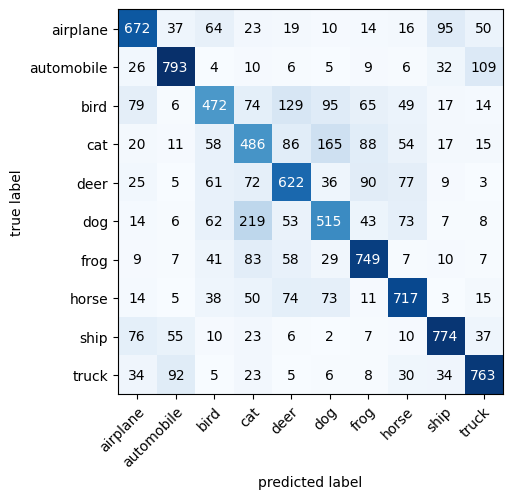

In [204]:
helper.model_eval_report(
    tiny_vgg_model_adam,
    test_dataloader,
    test_dataset,
    loss_function,
    f1,
    device
)

Можем посмотреть, что с чем модель путает.
- Из очевидного - кошку с собакой
- Оленя с птицой (видимо из-за цвета, окружения и рогов), хотя с конём путает меньше
- Самолет с кораблем и птицей.
- Машину с грузовиком

в целом эти результаты вполне ожидаемы, тк путаемые объекты похожи в некоторых своих свойствах, и на картинках 32х32 не особо то и много информации

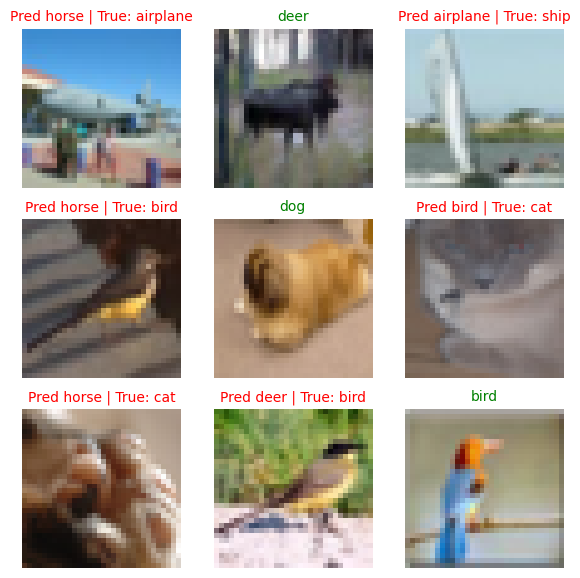

In [205]:
helper.plot_random_samples(
    test_data=test_dataset,
    model=tiny_vgg_model_adam,
    device=device,
    class_names=class_names,
    figsize=7,
    rows_cols=3,
)

## Adding batch normalization and dropouts

In [206]:
class TinyVGGModelWithBatchNormAndDropout(nn.Module):
    def __init__(self,
                 name: typing.AnyStr,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.name = name
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,  # channels
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=hidden_units),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=hidden_units),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=hidden_units),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=hidden_units),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=output_shape * 8 * 8,
                out_features=output_shape
            )
        )

    def forward(self, x):
        x = self.conv_block1(x)
        # print(x.shape)
        x = self.conv_block2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [221]:
torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)

tiny_vgg_model_adam_bn_dropout = TinyVGGModelWithBatchNormAndDropout(
    name="cnnVGG10/sched+bn+dropout",
    input_shape=3,
    hidden_units=10,
    output_shape=len(class_names)
).to(device)

RES_PATH = Path("model_res")
RES_PATH.mkdir(parents=True,
               exist_ok=True)
RES_NAME = "tinyVGGresults"
RES_SAVE_PATH = RES_PATH / RES_NAME

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

MODEL_NAME = "tinyVGGmodel.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

tiny_vgg_results_adam_bn_dropout_df = None

if os.path.exists(RES_SAVE_PATH) and os.path.exists(MODEL_SAVE_PATH):
    print("Loading existing model")
    tiny_vgg_results_adam_bn_dropout_df = pd.read_csv(RES_SAVE_PATH)

    for label in ["history_train_loss", "history_test_loss", "history_train_eval", "history_test_eval"]:
        nums = []
        tiny_vgg_results_adam_bn_dropout_df[label] = tiny_vgg_results_adam_bn_dropout_df[label].map(
            #TODO: Save to PICKLE!!
            lambda x:
            list(map(
                lambda y:
                float(y),
                x.strip('][').split(', ')
            ))
        )

    tiny_vgg_model_adam_bn_dropout.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
else:
    optimizer = torch.optim.Adam(
        params=tiny_vgg_model_adam_bn_dropout.parameters(),
        lr=0.003
    )
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    tiny_vgg_results_adam_bn_dropout = helper.model_trainer(
        model=tiny_vgg_model_adam_bn_dropout,
        epochs=30,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        loss_function=loss_function,
        optimizer=optimizer,
        eval_function=f1,
        device=device,
        scheduler=scheduler
    )
    model_results.append(tiny_vgg_results_adam_bn_dropout)
    tiny_vgg_results_adam_bn_dropout_df = pd.DataFrame([tiny_vgg_results_adam_bn_dropout])
    tiny_vgg_results_adam_bn_dropout_df.to_csv(RES_SAVE_PATH)
    print(f"Saving model to: {MODEL_SAVE_PATH}")
    torch.save(obj=tiny_vgg_model_adam_bn_dropout.state_dict(),
               # only saving the state_dict() only saves the learned parameters
               f=MODEL_SAVE_PATH)


Loading existing model


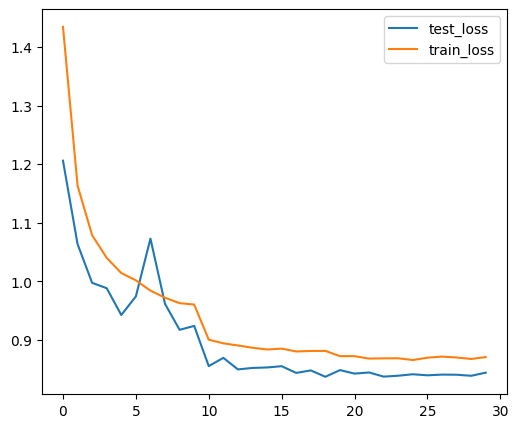

In [222]:
plt.rcParams['figure.figsize'] = [6, 5]
plt.plot(tiny_vgg_results_adam_bn_dropout_df.history_test_loss[0], label='test_loss')
plt.plot(tiny_vgg_results_adam_bn_dropout_df.history_train_loss[0], label='train_loss')
plt.legend()

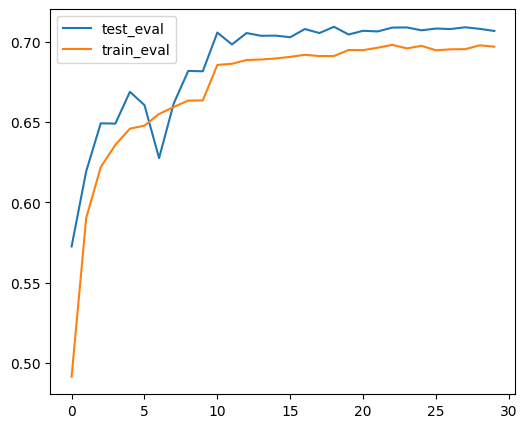

In [223]:
plt.rcParams['figure.figsize'] = [6, 5]
plt.plot(tiny_vgg_results_adam_bn_dropout_df.history_test_eval[0], label='test_eval')
plt.plot(tiny_vgg_results_adam_bn_dropout_df.history_train_eval[0], label='train_eval')
plt.legend()

  0%|          | 0/313 [00:00<?, ?it/s]

torch.Size([10000])
{'name': 'TinyVGGModelWithBatchNormAndDropout', 'loss': 0.8440792560577393, 'eval': 0.706569492816925, 'train_time': 0, 'predicted': tensor([3, 8, 8,  ..., 5, 1, 7], device='cuda:0')}
              precision    recall  f1-score   support

    airplane       0.77      0.68      0.73      1000
  automobile       0.88      0.80      0.84      1000
        bird       0.65      0.49      0.56      1000
         cat       0.54      0.49      0.51      1000
        deer       0.62      0.71      0.66      1000
         dog       0.60      0.64      0.62      1000
        frog       0.67      0.85      0.75      1000
       horse       0.82      0.71      0.76      1000
        ship       0.77      0.85      0.81      1000
       truck       0.77      0.84      0.80      1000

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.70     10000
weighted avg       0.71      0.71      0.70     10000



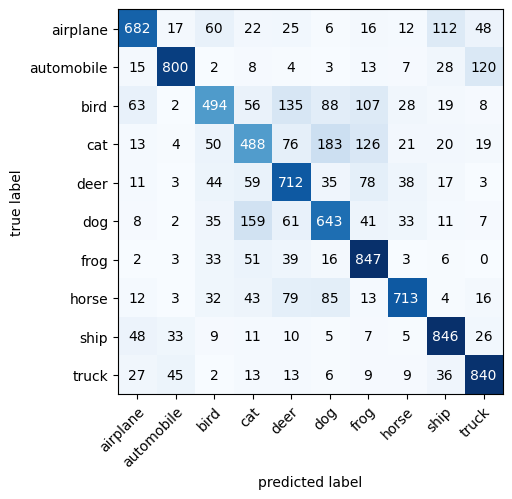

In [224]:
helper.model_eval_report(
    model=tiny_vgg_model_adam_bn_dropout,
    test_dataloader=test_dataloader,
    test_dataset=test_dataset,
    loss_function=loss_function,
    eval_function=f1,
    device=device,
)

Как можно заметить - результаты на 6% лучше, путаница в случайных местах почти теряется. Попробуем еще одну модель, которая должна гораздо лучше справляться чем голая TinyVGG

## VGG Mini

пробовал VGG11, но у меня взорвался компьютер(((

In [225]:
class VGG_mini(nn.Module):

    def __init__(self, name):
        super().__init__()
        self.name = name
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(num_features=512),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 128),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        # print(x.shape)
        x = self.conv_block1(x)
        # print(x.shape)
        x = self.conv_block2(x)
        # print(x.shape)
        x = self.conv_block3(x)
        # print(x.shape)
        x = self.conv_block4(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x


In [226]:
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

vgg_mini_model = VGG_mini(name="vggMini").to(device)

vgg_mini_model_results_df = None

RES_PATH = Path("model_res")
RES_PATH.mkdir(parents=True,
               exist_ok=True)
RES_NAME = "miniVGGresults"
RES_SAVE_PATH = RES_PATH / RES_NAME

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

MODEL_NAME = "miniVGGmodel.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

if os.path.exists(RES_SAVE_PATH) and os.path.exists(MODEL_SAVE_PATH):
    print("Loading existing model")
    vgg_mini_model_results_df = pd.read_csv(RES_SAVE_PATH)

    for label in ["history_train_loss", "history_test_loss", "history_train_eval", "history_test_eval"]:
        nums = []
        vgg_mini_model_results_df[label] = vgg_mini_model_results_df[label].map(  #TODO: Save to PICKLE!!
            lambda x:
            list(map(
                lambda y:
                float(y),
                x.strip('][').split(', ')
            ))
        )

    vgg_mini_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
else:
    optimizer = torch.optim.Adam(
        params=vgg_mini_model.parameters(),
        lr=0.01
    )
    scheduler = torch.optim.lr_scheduler.ExponentialLR(
        optimizer=optimizer,
        gamma=0.75,
        verbose=True
    )
    vgg_mini_model_results = helper.model_trainer(
        model=vgg_mini_model,
        epochs=50,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        loss_function=loss_function,
        optimizer=optimizer,
        eval_function=f1,
        device=device,
        scheduler=scheduler
    )
    vgg_mini_model_results_df = pd.DataFrame([vgg_mini_model_results])
    vgg_mini_model_results_df.to_csv(RES_SAVE_PATH)
    print(f"Saving model to: {MODEL_SAVE_PATH}")
    torch.save(obj=vgg_mini_model.state_dict(),  # only saving the state_dict() only saves the learned parameters
               f=MODEL_SAVE_PATH)

Loading existing model


После того как мы сохранили труды нашей видеокарты, время посмотреть, а что же она там наделала

In [227]:
final_res = vgg_mini_model_results_df

print(f"Total train time {final_res['train_time'][0] / 60:.2f} minutes")

Total train time 15.37 minutes


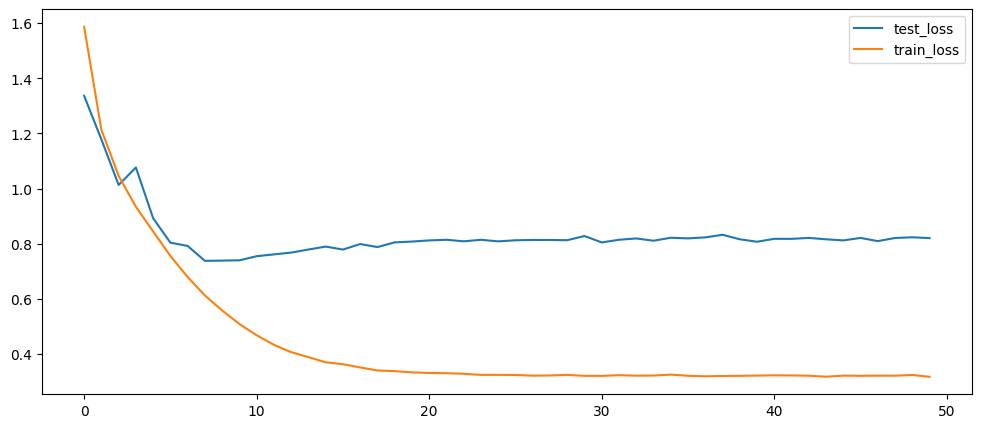

In [228]:
plt.rcParams['figure.figsize'] = [12, 5]
plt.plot(final_res.history_test_loss[0], label='test_loss')
plt.plot(final_res.history_train_loss[0], label='train_loss')
plt.legend()

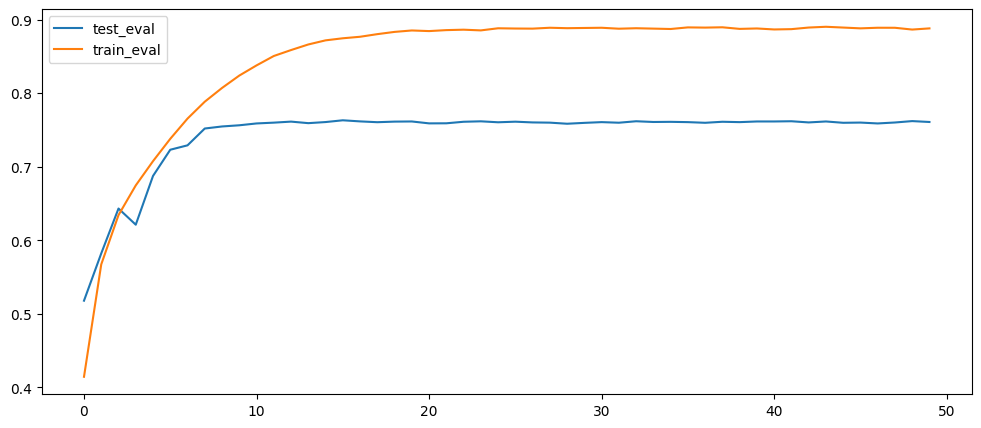

In [229]:
plt.rcParams['figure.figsize'] = [12, 5]
plt.plot(final_res.history_test_eval[0], label='test_eval')
plt.plot(final_res.history_train_eval[0], label='train_eval')
plt.legend()

Видим, что формально нам бы хватило 10 эпох, потому что дальше прогресс был только на трейне, но при этом не было никакого переобучения. Соответственно время обучения можно было сократить с 15 до 3-х минут.

Итоговая F1 - 75%, что конечно на 10% лучше, чем голая Tiny Vgg, но по документам там должно быть 80%. Возможно я не очень корректно перенёс модель.

  0%|          | 0/313 [00:00<?, ?it/s]

torch.Size([10000])
{'name': 'VGG_mini', 'loss': 0.8200173377990723, 'eval': 0.760882556438446, 'train_time': 0, 'predicted': tensor([3, 8, 8,  ..., 5, 0, 7], device='cuda:0')}
              precision    recall  f1-score   support

    airplane       0.76      0.81      0.79      1000
  automobile       0.89      0.86      0.87      1000
        bird       0.68      0.61      0.64      1000
         cat       0.59      0.63      0.61      1000
        deer       0.72      0.75      0.74      1000
         dog       0.68      0.65      0.66      1000
        frog       0.80      0.82      0.81      1000
       horse       0.82      0.79      0.80      1000
        ship       0.87      0.83      0.85      1000
       truck       0.81      0.86      0.83      1000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



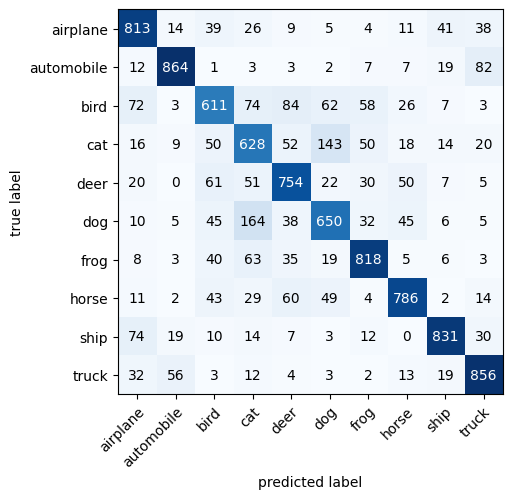

In [230]:
importlib.reload(helper)

helper.model_eval_report(
    model=vgg_mini_model,
    test_dataloader=test_dataloader,
    test_dataset=test_dataset,
    loss_function=loss_function,
    eval_function=f1,
    device=device
)

На некоторых классах f1 стремится аж к 90%, на некоторых только 60%. Рассмотрим, а почему так то

- 87% Автомобили, что ожидаемо, путаются почти только с грузовиками, в остальном они лучше всего распознаются
- 64% Птицы, вероятно из-за своей округлой формы в сидячем положении путаются с остальными зверями, и в расправленной форме с самолётами. (А еще есть страусы, которые по высоте как олени/кони и по цветам как они же)
- 61% Коты и собаки одно и то же, давайте признаем
- 66% Собаки и коты всё же одно и то же, давайте наконец это признаем


![](./images/dogcat.png)
![](./images/airplane.png)
![](./images/truck.png)

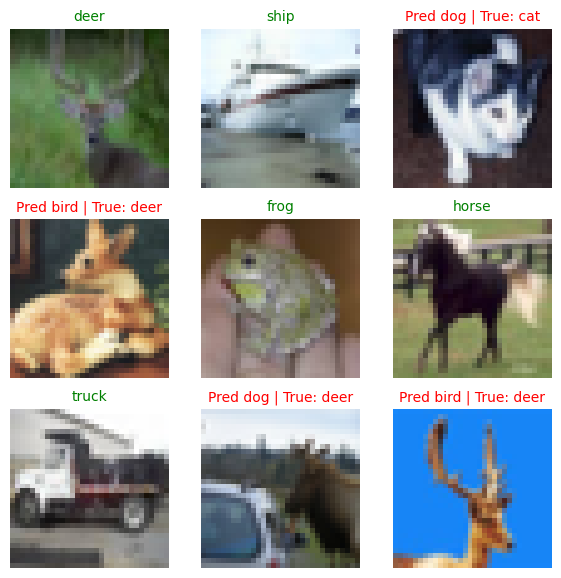

In [231]:
helper.plot_random_samples(
    test_data=test_dataset,
    model=vgg_mini_model,
    device=device,
    class_names=class_names,
    figsize=7,
    rows_cols=3,
)

Рассмотрим нашу итоговую табличку моделей

In [233]:
final_df = pd.DataFrame(model_results)
final_df = pd.concat([final_df, vgg_mini_model_results_df])
final_df

,name,class_name,status,epochs_remain,on_which_batch_broken,train_time,loss_function,optimizer,learning_rate,eval_function,device,end_test_loss,end_test_eval,end_train_loss,end_train_eval,history_test_loss,history_test_eval,history_train_loss,history_train_eval,Unnamed: 0
0,fcl10/1,FullyConnectedLinearModel,TrainStatus.GradientExplosion,2,17.0,12.351602,CrossEntropyLoss,SGD,1.000000e+00,MulticlassF1Score,cuda,0.000000,0.000000,0.000000,0.000000,[],[],[0],[0],NaN
1,fcnl10/1,FullyConnectedNonLinearModel,TrainStatus.Success,0,NaN,34.950865,CrossEntropyLoss,SGD,1.000000e+00,MulticlassF1Score,cuda,2.360345,0.099740,2.360978,0.100048,"[2.26325, 2.36091, 2.36035]","[0.1903, 0.10014, 0.09974]","[2.25259, 2.36014, 2.36098]","[0.18658, 0.10087, 0.10005]",NaN
2,fcl100/1,FullyConnectedLinearModel,TrainStatus.GradientExplosion,2,17.0,0.178372,CrossEntropyLoss,SGD,1.000000e+00,MulticlassF1Score,cuda,0.000000,0.000000,0.000000,0.000000,[],[],[0],[0],NaN
3,fcnl100/1,FullyConnectedNonLinearModel,TrainStatus.Success,0,NaN,27.408624,CrossEntropyLoss,SGD,1.000000e+00,MulticlassF1Score,cuda,2.358540,0.102536,2.355825,0.105326,"[2.35778, 2.361, 2.35854]","[0.10323, 0.10014, 0.10254]","[2.27318, 2.33785, 2.35582]","[0.17702, 0.12296, 0.10533]",NaN
4,fcl1000/1,FullyConnectedLinearModel,TrainStatus.GradientExplosion,2,17.0,0.289406,CrossEntropyLoss,SGD,1.000000e+00,MulticlassF1Score,cuda,0.000000,0.000000,0.000000,0.000000,[],[],[0],[0],NaN
5,fcnl1000/1,FullyConnectedNonLinearModel,TrainStatus.Success,0,NaN,28.550635,CrossEntropyLoss,SGD,1.000000e+00,MulticlassF1Score,cuda,2.359500,0.101637,2.343693,0.117442,"[2.30936, 2.3573, 2.3595]","[0.15156, 0.10383, 0.10164]","[2.25774, 2.32111, 2.34369]","[0.19168, 0.13974, 0.11744]",NaN
6,fcl10/0.1,FullyConnectedLinearModel,TrainStatus.GradientExplosion,2,88.0,0.518521,CrossEntropyLoss,SGD,1.000000e-01,MulticlassF1Score,cuda,0.000000,0.000000,0.000000,0.000000,[],[],[0],[0],NaN
7,fcnl10/0.1,FullyConnectedNonLinearModel,TrainStatus.Success,0,NaN,26.485830,CrossEntropyLoss,SGD,1.000000e-01,MulticlassF1Score,cuda,2.152829,0.297224,2.154085,0.296265,"[2.20007, 2.18951, 2.15283]","[0.2474, 0.25419, 0.29722]","[2.23992, 2.17714, 2.15408]","[0.19746, 0.27017, 0.29627]",NaN
8,fcl100/0.1,FullyConnectedLinearModel,TrainStatus.GradientExplosion,2,88.0,0.449692,CrossEntropyLoss,SGD,1.000000e-01,MulticlassF1Score,cuda,0.000000,0.000000,0.000000,0.000000,[],[],[0],[0],NaN
9,fcnl100/0.1,FullyConnectedNonLinearModel,TrainStatus.Success,0,NaN,26.362987,CrossEntropyLoss,SGD,1.000000e-01,MulticlassF1Score,cuda,2.112154,0.338958,2.101976,0.352387,"[2.16084, 2.11581, 2.11215]","[0.29113, 0.33836, 0.33896]","[2.20676, 2.13188, 2.10198]","[0.23377, 0.32258, 0.35239]",NaN


#### (я забыл сохранить табличку выше, поэтому её не трогать, и если что откатывать по гиту)

## Финальная проба - загрузим толстенную модель и попробуем трансфер обучения

In [22]:
vgg16 = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.IMAGENET1K_V1).to(device)
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [23]:
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)


class PassLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x


for param in vgg16.parameters():
    param.requires_grad = False


vgg16.classifier[3].requires_grad = True

vgg16.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 512),
                      nn.ReLU(),
                      nn.Dropout(0.5),
                      nn.Linear(512, 10))

# vgg16.classifier \
#     .append(nn.Linear(in_features=1000, out_features=100)) \
#     .append(nn.ReLU(inplace=True)) \
#     .append(nn.Dropout()) \
#     .append(nn.Linear(in_features=100, out_features=10))
# vgg11.classifier[7] =
vgg16.name = "vgg16"
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [32]:
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

print("Params to learn:")
params_to_update = []
for name, param in vgg16.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)
        print("\t", name)

optimizer = torch.optim.Adam(params=params_to_update, lr=0.0001)

Params to learn:
	 classifier.6.0.weight
	 classifier.6.0.bias
	 classifier.6.3.weight
	 classifier.6.3.bias


In [25]:
# randtens = torch.randn((1, 3, 32, 32), device=device)
# vgg11.to(device=device)
# vgg11.eval()
# vgg11(randtens).shape

Меняем данные, потому что vgg трейнилась на imagenet и нам нужно то же преобразование.

In [39]:
custom_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset2 = datasets.CIFAR10(root='dataСifar2',
                                  train=True,
                                  transform=custom_transform,
                                  download=True)

test_dataset2 = datasets.CIFAR10(root='dataСifar2',
                                 train=False,
                                 transform=custom_transform,
                                 download=True)

train_dataloader2 = DataLoader(dataset=train_dataset2,
                               batch_size=BATCH_SIZE,
                               num_workers=NUM_WORKERS,
                               persistent_workers=True,
                               shuffle=True)

test_dataloader2 = DataLoader(dataset=test_dataset2,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              persistent_workers=True,
                              shuffle=False)

for images, labels in train_dataloader2:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Files already downloaded and verified
Files already downloaded and verified
Image batch dimensions: torch.Size([32, 3, 224, 224])
Image label dimensions: torch.Size([32])


In [ ]:
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

MODEL_NAME = "VGG16model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME



if os.path.exists(MODEL_SAVE_PATH):
    print("Loading existing model")
    vgg16.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
else:
    helper.model_trainer(
        model=vgg16,
        epochs=10,
        test_dataloader=test_dataloader2,
        train_dataloader=train_dataloader2,
        loss_function=loss_function,
        optimizer=optimizer,
        eval_function=f1,
        device=device,
        # scheduler=torch.optim.lr_scheduler.ExponentialLR(
        #     optimizer=optimizer,
        #     gamma=0.75,
        #     verbose=True
        # ),
    )
    print(f"Saving model to: {MODEL_SAVE_PATH}")
    torch.save(obj=vgg16.state_dict(),
               f=MODEL_SAVE_PATH)

Короче я тут чуть ли не руками итеративно подбирал lr, но у меня уже просто терпения не хватило ждать 85+ скор (хотя там к 95%+ он должен как-то выходить)

Поскольку модель вышла 500мб, то и сгружать на гит я её не буду, поэтому предлагаю просто глянуть результаты ниже, оценить полученные 10% от готовой модели.

(Еще была такая ситуация - что во время дообучения скор на трэйне был ~100%, но при итерациях падал, вне зависимости от подобранного ЛР, а на тесте скор не рос при этом)

  0%|          | 0/313 [00:00<?, ?it/s]

torch.Size([10000])
{'name': 'VGG', 'loss': 0.45728781819343567, 'eval': 0.8466453552246094, 'train_time': 0, 'predicted': tensor([3, 8, 8,  ..., 5, 1, 7], device='cuda:0')}
              precision    recall  f1-score   support

    airplane       0.86      0.88      0.87      1000
  automobile       0.90      0.90      0.90      1000
        bird       0.86      0.79      0.82      1000
         cat       0.77      0.70      0.73      1000
        deer       0.76      0.84      0.80      1000
         dog       0.79      0.81      0.80      1000
        frog       0.84      0.90      0.87      1000
       horse       0.89      0.83      0.86      1000
        ship       0.89      0.92      0.90      1000
       truck       0.91      0.90      0.90      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



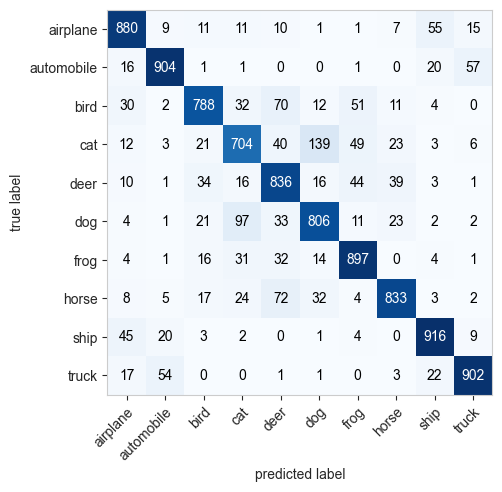

In [38]:
helper.model_eval_report(
    model=vgg16,
    test_dataset=test_dataset2,
    test_dataloader=test_dataloader2,
    loss_function=loss_function,
    eval_function=f1,
    device=device
)

Ну и несмотря на 85% макро - результаты выглядят очень вкусно, но все так же кошки с собаками путаются и птицы с оленями.